# Fashion Product Images Dataset - Data Preprocessing

# 1. Dataset Overview
- **Goal**: The dataset is designed for **fashion product classification and recommendation**. 
It contains a various collection of labeled images of fashion items that allows us to develop intelligent systems that is applicable for : 
**Product classification** by training machine learning to classify  fashion items into multiple categories such as pants, t-shirts and shoes.
**Recommendation system** by training machine learning to recommend similar fashion items based on a given image.
This dataset not only improve automation and efficiency in fashion industry but also improve user experience throughout tailored recommendation capabilities.
- **Source**: [Kaggle Dataset](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset)
- **Data Files inside Dataset/preprocessed**:
  - `preprocessed/`: Contains all the data after preprocessing.
  - `fashion_products_cleaned_final.csv`: Contains product metadata.
  - `fashion_products_cleaned_final.json`: Contains JSON metadata.
  - `resized_images/`: Contains `.jpg` images of products.
  
- **Number of Observations (Rows)**:
  - Total records: 44424
- **Number of Variables (Columns)**:
  - Total columns: 15
- **Types of Variables**:
  - Categorical (String): 13
  - Numerical (Integer/Float): 3

- **Classes and Labels**:
  - Primary Categories (masterCategory):
  - Apparel (48%)
  - Accessories (25%)
  - Other (26%)
  - Subcategories (subCategory):
  - Topwear (35%)
  - Shoes (17%)
  - Other (49%)
  - Article Type (articleType):
  - T-shirts (16%)
  - Shirts (7%)
  - Other (77%)
  - Gender Target (gender):
  - Men (50%)
  - Women (42%)
  - Other (8%)
  -  Brand (brandName)
  - Various brands represented in the dataset
  - Age Group (ageGroup)
  - Children, Adults, and Unspecified
  - Price (price) & Discounted Price (discountedPrice)
  - Varies across products
  - Season (season)
  - Summer, Winter, and other seasonal classifications
  - Usage (usage)
  - Casual, Formal, and other usage type
  
- **Attributes (Column Names and Description)**:
  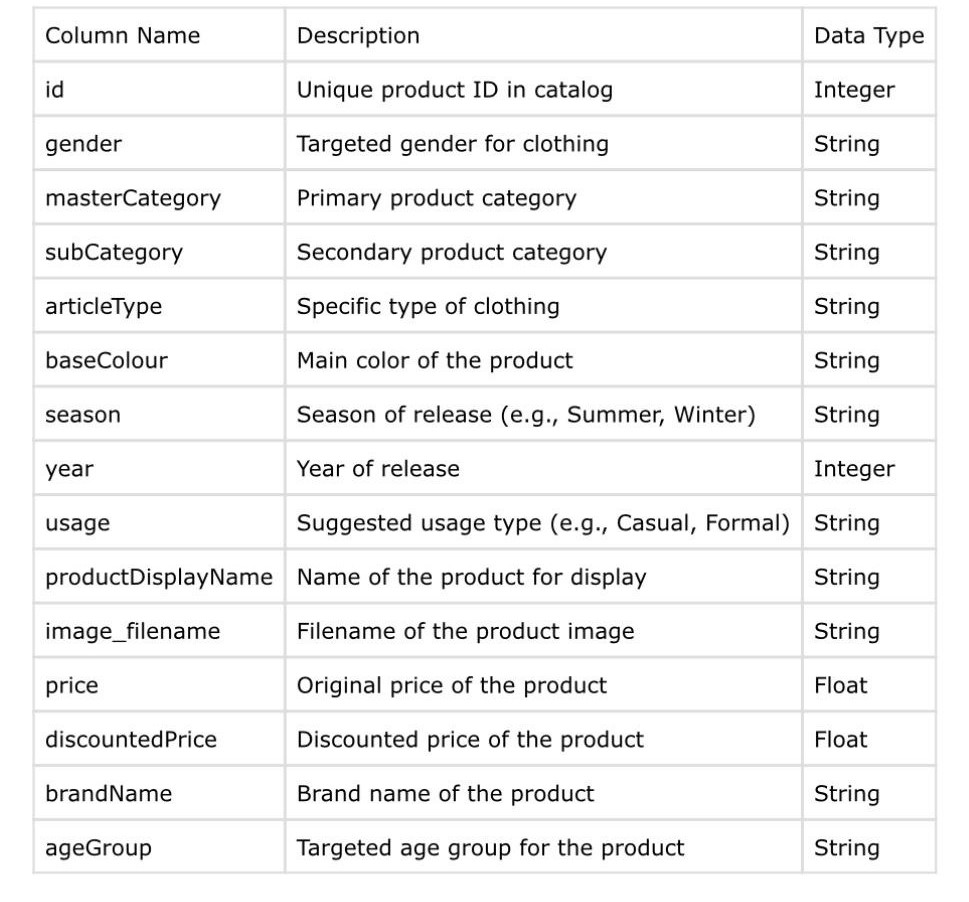

In [7]:
import pandas as pd
import os
import json
from PIL import Image

In [9]:
# File paths
csv_file_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"
styles_json_dir = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles"
image_dir = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"

In [20]:
# Output folder for saving results
output_dir = "/kaggle/working/preprocessed/resized_images/"
os.makedirs(output_dir, exist_ok=True)  # folder for resized images
preprocessed_folder = "/kaggle/working/preprocessed/"
os.makedirs(preprocessed_folder, exist_ok=True)  # folder for preprocessed data

# 2. Summary of the dataset

### Here is a sample of the raw dataset:
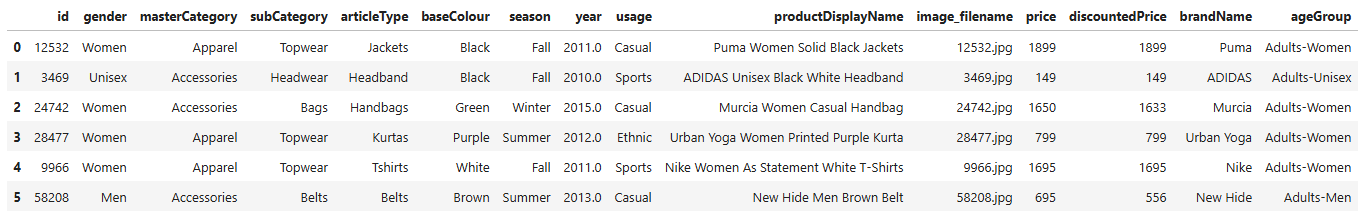

- The dataset has a total number of records: 44424.
- **Mode of Gender and Season**
  The most frequent gender in the dataset is Men, and the most frequent season is Summer.
- **Mean of attribute 'year'** 
 is 2012.8064.
- **Variance of attribute 'year'** 
 is 4.5219.
- **Gender Distribution** 
The figure below visualizes the distribution of gender in the dataset.


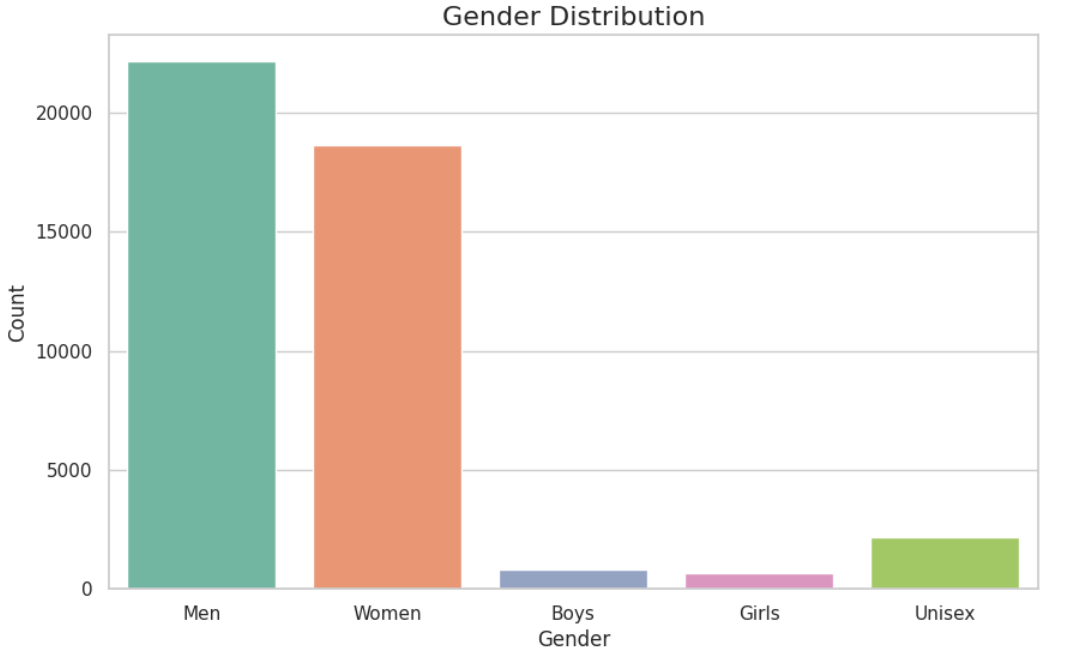

- **Master Category Distribution**
The figure shows the distribution of products across different master categories (e.g., Apparel, Accessories). It helps us understand which product categories are more prevalent in the dataset.


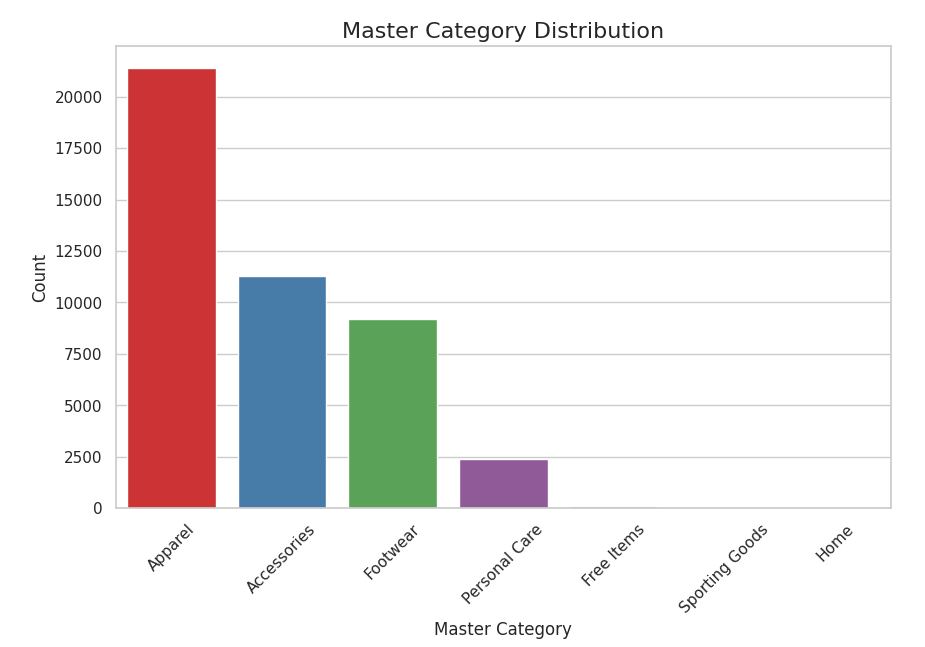

- **Subcategories Distribution**
This third plot displays the top 20 subcategories by count, revealing the most common types of products within the dataset. For example, T-shirts and Jeans may appear as the top products in the Apparel category.


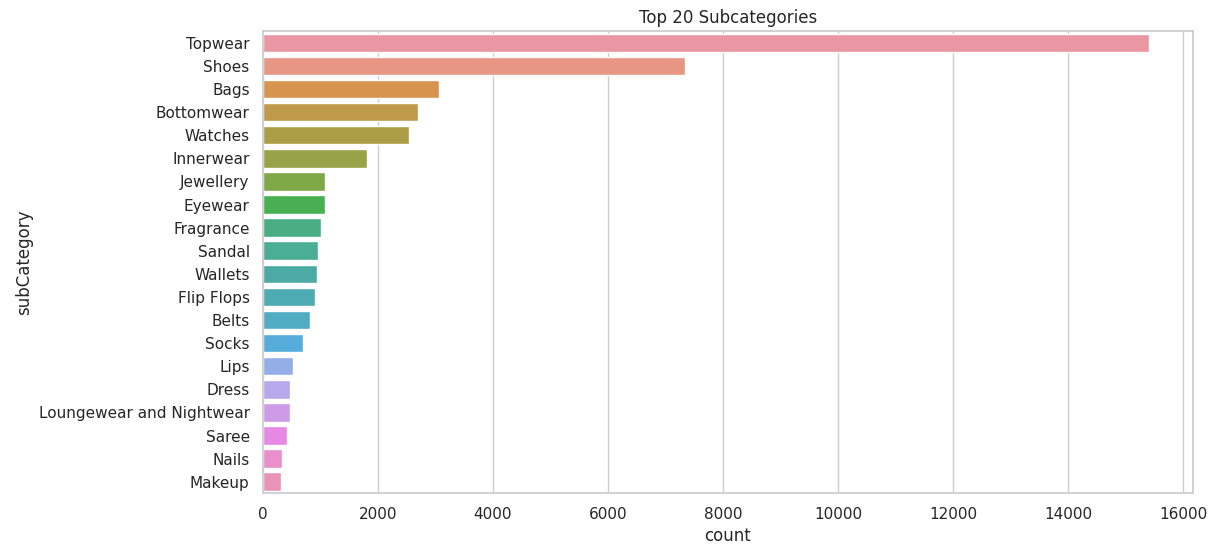

- **Article Types Distribution**
The figure below visualizes the top 20 article types by count, showing the most frequent specific product types.


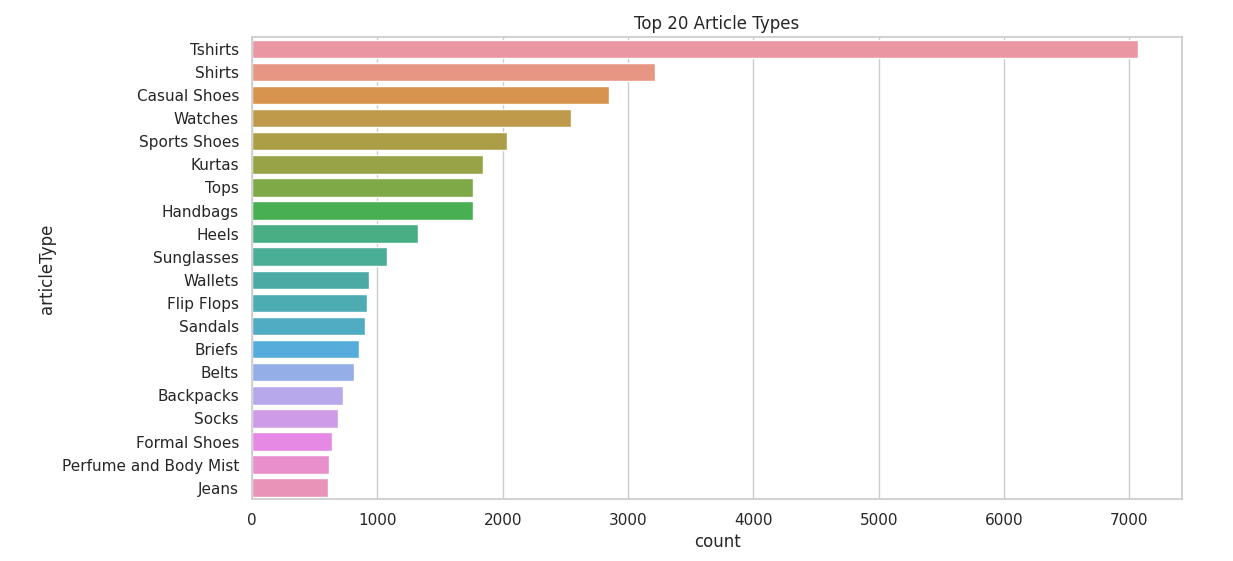

- **Null Value Distribution**
The final chart in our dataset summary shows the count of null (missing) values for each column if any. It highlights the columns where data might be missing, helping us identify where cleaning may be needed.


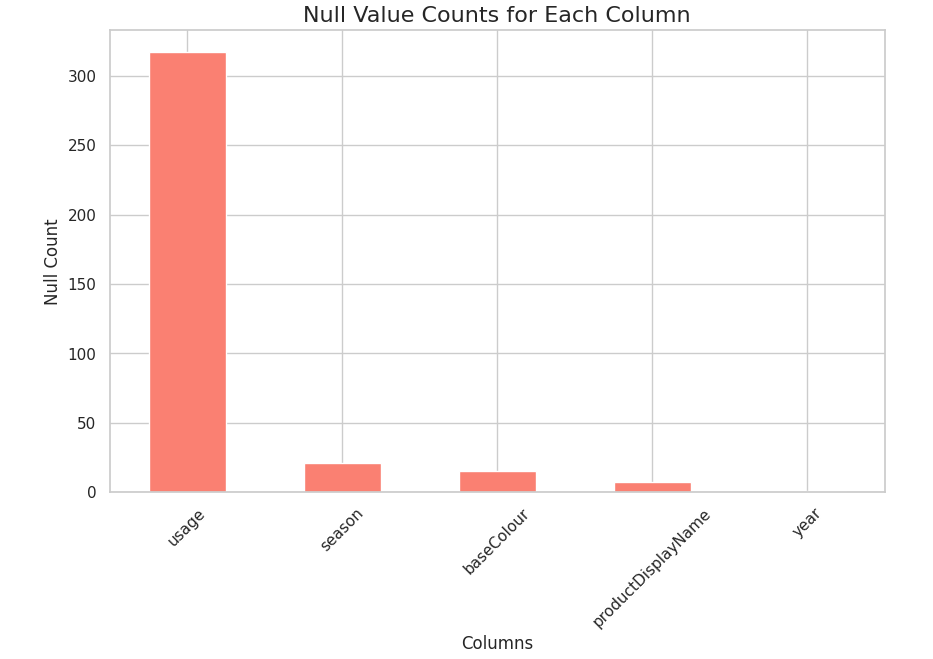


# 3. Preprocessing techniques

## 1. Extracting Required Fields & Renaming Columns

We considered normalizing price and discountedPrice for recommendation purposes. However, after further analysis, we decided NOT to normalize prices because Keeping raw prices allows the recommendation system to suggest products in a similar price range, and it allows customers to get better price-matching suggestions.

## 2. Filtering the dataset based on the subCategory and Handling Missing Values

## 3. Image Preprocessing (Resizing)

## 4. Save Preprocessed Data
The final files are fashion_products_cleaned.csv and fashion_products_cleaned.json .